In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
import cv2
from google.colab.patches import cv2_imshow

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
batch_size = 100
img_height = 224
img_width = 224


In [4]:
training_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/DL_Project/data/train',
    image_size= (img_height, img_width),
    batch_size=batch_size)

testing_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/DL_Project/data/test',
    image_size= (img_height, img_width),
    batch_size=batch_size)

validation_ds =  tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/DL_Project/data/val',
    image_size= (img_height, img_width),
    batch_size=batch_size)

Found 791 files belonging to 2 classes.
Found 100 files belonging to 2 classes.
Found 98 files belonging to 2 classes.


In [5]:
class_names = training_ds.class_names
class_names

['Accident', 'Non Accident']

In [6]:
img_shape = (img_height, img_width, 3)
base_model = VGG16(input_shape=img_shape, include_top=False, weights='imagenet')
base_model.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [7]:
def attention_layer(inputs):
    a = Dense(time_steps, activation='softmax')(inputs)
    a = Dot(axes=1)([a, inputs])
    a = Activation('tanh')(a)
    return a



In [8]:
import tensorflow as tf
from tensorflow.keras import layers

# Define a custom layer for channel-wise attention
class ChannelAttention(layers.Layer):
    def __init__(self, ratio=8, **kwargs):
        super(ChannelAttention, self).__init__(**kwargs)
        self.ratio = ratio

    def build(self, input_shape):
        channel = input_shape[-1]
        self.shared_layer_one = layers.Conv2D(channel//self.ratio, (1, 1), padding='same', activation='relu', kernel_initializer='he_normal')
        self.shared_layer_two = layers.Conv2D(channel, (1, 1), padding='same', activation='sigmoid', kernel_initializer='he_normal')
        super(ChannelAttention, self).build(input_shape)

    def call(self, inputs):
        shared_layer_one_output = self.shared_layer_one(inputs)
        shared_layer_two_output = self.shared_layer_two(shared_layer_one_output)
        return tf.multiply(inputs, shared_layer_two_output)

# Define a base model, for example, VGG16
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Build the model with channel-wise attention
model = tf.keras.Sequential([
    base_model,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.Conv2D(128, 3, activation='relu'),

    # Apply channel-wise attention using the custom layer
    ChannelAttention(),

    layers.Flatten(),
    layers.Dense(2, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 32)          147488    
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 3, 64)          18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 1, 128)         73856     
                                                                 
 channel_attention (Channel  (None, 1, 1, 128)         4240      
 Attention)                                                      
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                        

In [9]:
history = model.fit(training_ds, validation_data = validation_ds, epochs = 5)

Epoch 1/5
8/8 [==============================] - 350s 16s/step - loss: 12.1630 - accuracy: 0.4728 - val_loss: 0.9223 - val_accuracy: 0.5306
Epoch 2/5
8/8 [==============================] - 16s 1s/step - loss: 0.7305 - accuracy: 0.5044 - val_loss: 0.6897 - val_accuracy: 0.5000
Epoch 3/5
8/8 [==============================] - 18s 1s/step - loss: 0.6944 - accuracy: 0.4943 - val_loss: 0.7010 - val_accuracy: 0.5306
Epoch 4/5
8/8 [==============================] - 16s 1s/step - loss: 0.7034 - accuracy: 0.5411 - val_loss: 0.6904 - val_accuracy: 0.5102
Epoch 5/5
8/8 [==============================] - 16s 1s/step - loss: 0.6997 - accuracy: 0.5702 - val_loss: 0.7389 - val_accuracy: 0.5000


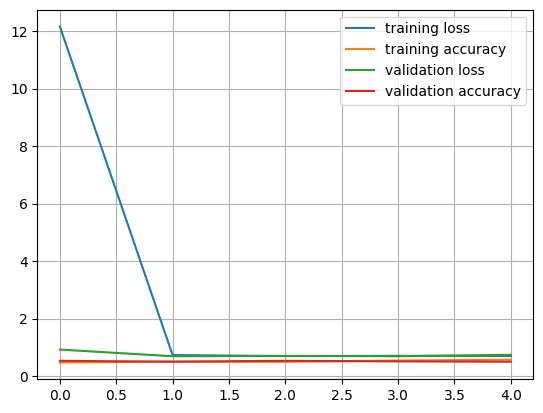

In [10]:
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['accuracy'], label = 'training accuracy')
plt.grid(True)
plt.legend()

plt.plot(history.history['val_loss'], label = 'validation loss')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.grid(True)
plt.legend()

In [11]:
#Visualize predictionss
AccuracyVector = []
plt.figure(figsize=(40, 40))
for images, labels in testing_ds.take(1):
    predictions = model.predict(images)
    predlabel = []
    prdlbl = []

    for mem in predictions:
        predlabel.append(class_names[np.argmax(mem)])
        prdlbl.append(np.argmax(mem))

    AccuracyVector = np.array(prdlbl) == labels
    for i in range(20):
        ax = plt.subplot(10, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        if (predlabel[i] == class_names[labels[i]]):
          plt.title('Pred: '+ predlabel[i]+' Actl:'+class_names[labels[i]], color = "green")
        else:
          plt.title('Pred: '+ predlabel[i]+' Actl:'+class_names[labels[i]], color = "red")
        plt.axis('off')
        plt.grid(True)

Output hidden; open in https://colab.research.google.com to view.

In [12]:
truePositive=0
trueNegative=0
falsePositive=0
falseNegative=0
#positive: accident
#negative: non accident
for i in range(0, 100):
    if(predlabel[i]==class_names[labels[i]] and predlabel[i]=='Accident'):
        truePositive+=1
    elif(predlabel[i]==class_names[labels[i]] and predlabel[i]=='Non Accident'):
        trueNegative+=1
    elif(predlabel[i]=='Non Accident' and class_names[labels[i]]=='Accident'):
        falseNegative+=1
    else:
        falsePositive+=1

In [13]:
print(f'True positives are: {truePositive}')
print(f'True negatives are: {trueNegative}')
print(f'False negatives are: {falseNegative}')
print(f'False positives are: {falsePositive}')

True positives are: 37
True negatives are: 13
False negatives are: 10
False positives are: 40


In [14]:
from sklearn.metrics import classification_report

y_true = np.concatenate([y for x, y in testing_ds])

y_pred = model.predict(testing_ds)
y_pred = np.argmax(y_pred, axis=1)

report = classification_report(y_true, y_pred, target_names=class_names)

print(report)

1/1 [==============================] - 1s 816ms/step
              precision    recall  f1-score   support

    Accident       0.42      0.68      0.52        47
Non Accident       0.35      0.15      0.21        53

    accuracy                           0.40       100
   macro avg       0.38      0.42      0.36       100
weighted avg       0.38      0.40      0.35       100



1/1 [==============================] - 1s 711ms/step


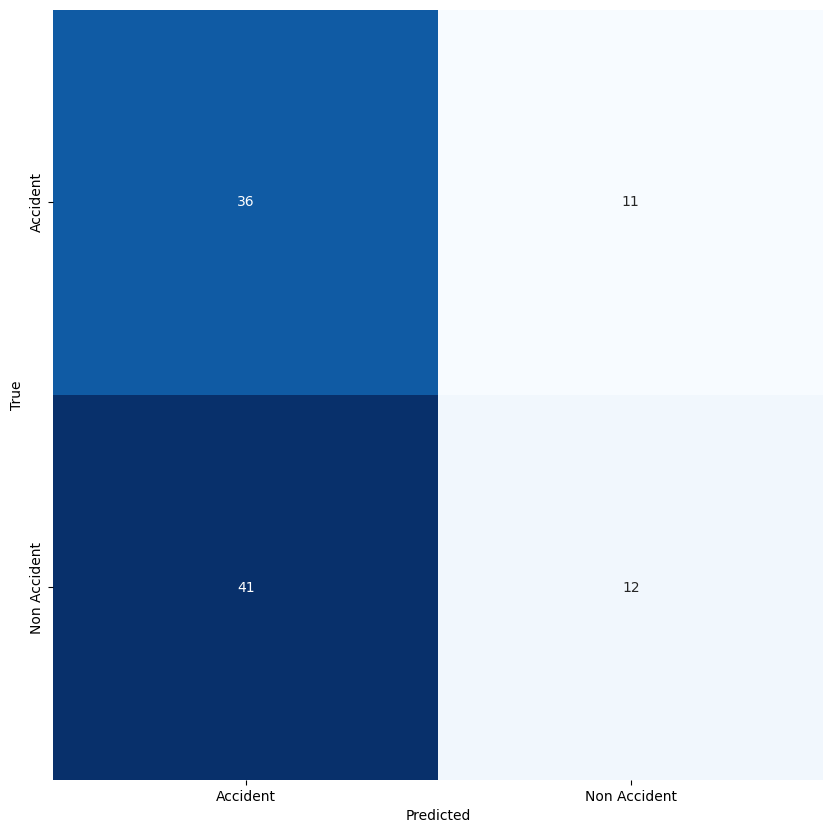

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_true = np.concatenate([y for x, y in testing_ds])

y_pred = model.predict(testing_ds)
y_pred = np.argmax(y_pred, axis=1)

conf_mat = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 10))
sns.heatmap(conf_mat, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=class_names, yticklabels=class_names, cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [16]:
def predict_frame(img):
    img_array = tf.keras.utils.img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)
    prediction=(model.predict(img_batch) > 0.5).astype("int32")
    if(prediction[0][0]==0):
        return("Accident Detected")
    else:
        return("No Accident")

In [17]:
import cv2
image=[]
label=[]

c=1
cap= cv2.VideoCapture('/content/drive/MyDrive/DL_Project/car_accident.mp4')
while True:
    grabbed, frame = cap.read()
    if c%30==0:
        print(c)
        resized_frame=tf.keras.preprocessing.image.smart_resize(frame, (img_height, img_width), interpolation='bilinear')
        image.append(frame)
        label.append(predict_frame(resized_frame))
        if(len(image)==75):
            break
    c+=1

cap.release()

30
1/1 [==============================] - 1s 1s/step
60
1/1 [==============================] - 0s 27ms/step
90
1/1 [==============================] - 0s 28ms/step
120
1/1 [==============================] - 0s 28ms/step
150
1/1 [==============================] - 0s 37ms/step
180
1/1 [==============================] - 0s 25ms/step
210
1/1 [==============================] - 0s 38ms/step
240
1/1 [==============================] - 0s 40ms/step
270
1/1 [==============================] - 0s 30ms/step
300
1/1 [==============================] - 0s 29ms/step
330
1/1 [==============================] - 0s 29ms/step
360
1/1 [==============================] - 0s 25ms/step
390
1/1 [==============================] - 0s 26ms/step
420
1/1 [==============================] - 0s 29ms/step
450
1/1 [==============================] - 0s 26ms/step
480
1/1 [==============================] - 0s 29ms/step
510
1/1 [==============================] - 0s 29ms/step
540
1/1 [==============================] - 0s 28ms/st

No Accident
AxesImage(size=(360, 640))


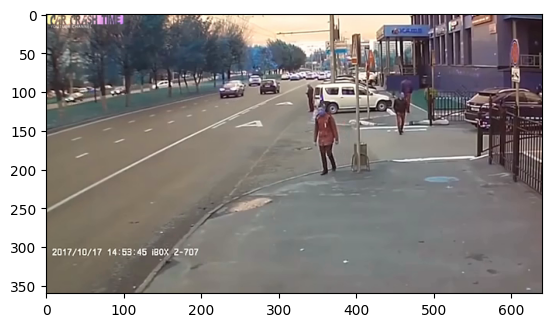

In [18]:
print(label[20])
print(plt.imshow(image[20]))

No Accident
AxesImage(size=(360, 640))


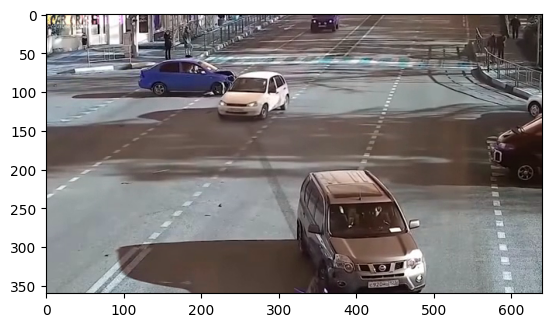

In [19]:
print(label[5])
print(plt.imshow(image[5]))

Accident Detected
AxesImage(size=(360, 640))


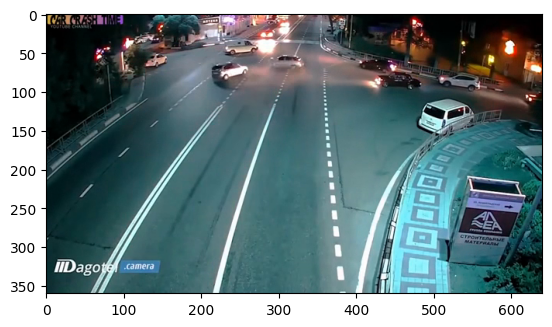

In [20]:
print(label[13])
print(plt.imshow(image[13]))